# Installation and setup

The gym environment requires an older version numpy (and corresponding packages). <br>
The following cell contains the `requirements.txt` to setup the python environment used in the rest of this notebook.


In [2]:
%%writefile requirements.txt

cloudpickle==3.1.1
contourpy==1.3.0
cycler==0.12.1
filelock==3.18.0
fonttools==4.56.0
fsspec==2025.3.0
gym==0.26.2
gym-notices==0.0.8
importlib_metadata==8.6.1
importlib_resources==6.5.2
Jinja2==3.1.6
kiwisolver==1.4.7
MarkupSafe==3.0.2
matplotlib==3.9.4
#outdated visualizer in github for textViz.py in Visualizer
#matplotlib==3.3.4 #3.5.0 is minimum for pyrddl 1.0 (the lowest versions)
mpmath==1.3.0
networkx==3.2.1
numpy==1.26.4
nvidia-cublas-cu12==12.4.5.8
nvidia-cuda-cupti-cu12==12.4.127
nvidia-cuda-nvrtc-cu12==12.4.127
nvidia-cuda-runtime-cu12==12.4.127
nvidia-cudnn-cu12==9.1.0.70
nvidia-cufft-cu12==11.2.1.3
nvidia-curand-cu12==10.3.5.147
nvidia-cusolver-cu12==11.6.1.9
nvidia-cusparse-cu12==12.3.1.170
nvidia-cusparselt-cu12==0.6.2
#nvidia-nccl-cu12==2.21.5 #Linux specific, install directly from pytorch index link and don't install this manually.
nvidia-nvjitlink-cu12==12.4.127
nvidia-nvtx-cu12==12.4.127
packaging==24.2
pillow==11.1.0
ply==3.11
pygame==2.6.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
six==1.17.0
sympy==1.13.1
torch==2.6.0
tqdm==4.67.1
#triton==3.2.0 ##Linux specific, install directly from pytorch index link and don't install this manually.
zipp==3.21.0
pyRDDLGym

Overwriting requirements.txt


Now install the requirements.

You may be asked to restart the session to load the installed versions of the packages. If so, restart the session and continue using the notebook

In [3]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------------------------ --------------- 4.7/7.8 MB 25.9 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.1
    Uninstalling matplotlib-3.10.1:
      Successfully uninstalled matplotlib-3.10.1


  You can safely remove it manually.


We will use a discretized version of
the [elevator domain](https://ataitler.github.io/IPPC2023/elevator.html) from the International Planning Competition, 2023.

Install the pyRDDL gym environment using the given repository.

In [2]:
!pip install -q git+https://github.com/June-Han/pyRDDLGym_NUS.git --force-reinstall

## Install other packages if needed

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import itertools
import numpy as np
import random
import tqdm
import IPython
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from collections import deque

from pyRDDLGym.Visualizer.MovieGenerator import MovieGenerator # loads visualizer utilites
from IPython.display import Image, display, clear_output # for displaying gifs in colab
from pyRDDLGym.Elevator import Elevator # imports Discrete Elevator

## Add more imports here as required

# Environment Initialization

In [9]:
## IMPORTANT: Do not change the instance of the environment.
env = Elevator(instance = 5)

print('Discrete environment actions:')
print(env.disc_actions)
print('Continuous environment actions:')
print(env.base_env.action_space)
print(f"Observation space size for the discrete Elevator Environment: {len(env.disc_states)}")

C:\Users\julia\Documents\GitHub\DiscreteRLAlgo\RLvenv\lib\site-packages\pyRDDLGym\Examples C:\Users\julia\Documents\GitHub\DiscreteRLAlgo\RLvenv\lib\site-packages\pyRDDLGym\Examples\manifest.csv
Available example environment(s):
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
HVAC -> Multi-zone and multi-heater HVAC control problem
MarsRover -> Multi Rover Navigation, where a group of agent needs to harvest mineral.
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
New

# Hyperparameters

In [12]:
# Define hyperparameters

## IMPORTANT: <BEGIN> DO NOT CHANGE THIS CODE!
## GENERAL HYPERPARAMS
num_episodes = 3000
## IMPORTANT: <END> DO NOT CHANGE THIS CODE!

learning_rate = 1e-4
batch_size = 64
clip_value = 1.0  # Gradient clipping value
gamma = 0.8
planning_steps = 10
epsilon_decay = 0.998
epsilon = 1.0
epsilon_min = 0.05

## ALGO SPECIFIC HYPERPARAMS
# Update the hyperparams as necessary for your implementation


# Model Definition

Define your model here. You can rename the class `YourModel` appropriately and use it later in the code.
Note: In case of actor-critic or other models, all components must subclass `nn.Module`

- Your model should take in 11 inputs, which will be derived from the convert_state_to_list function.
- Your model should return 6 values corresponding to action logits or probabilities.

In [15]:
class YourModel(nn.Module):
    def __init__(self):
        super(YourModel, self).__init__()
        # Your model layers and initializations here


    def forward(self, x):
        # x will be a tensor with shape [batch_size, 11]
        # Your forward pass logic here
        # Ensure the output has shape [batch_size, 6]
        return output

In [17]:
class QNetwork(nn.Module):
    def __init__(self, input_states, output_actions, hidden_size):
        super(QNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_states, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(),
            nn.Linear(hidden_size, output_actions)
        )

    def forward(self, x):
      return self.net(x)

In [19]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.index = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.index] = (state, action, reward, next_state, done)
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [21]:
#Unused
class TransitionModel(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(obs_dim + act_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, obs_dim + 1)  # next_state + reward
        )

    def forward(self, state, action):
        input = torch.cat([state, action], dim=-1)
        return self.model(input)

# Feature Extraction

In [24]:
## IMPORTANT: DO NOT CHANGE THIS CODE!
env_features = list(env.observation_space.keys())

def convert_state_to_list(state, env_features):
    out = []
    for i in env_features:
        out.append(state[i])
    return out

# Neural Net Initialization

In [27]:
# Initialize the network and optimizer
input_size = len(env_features)
output_size = 6

# INITIALIZE OTHER NETWORK PARAMS HERE
hidden_size = 128

# INITIALIZE YOUR NETWORK HERE
Qnet = QNetwork(input_size, output_size, hidden_size)
targetNet = QNetwork(input_size, output_size, hidden_size)

# INIT OPTIMIZER - Adam is a good start, but you can try changing this as well
optimizer = optim.Adam(
    Qnet.parameters(), lr=learning_rate
)
replay_buffer = ReplayBuffer(capacity=10000)

In [28]:
# Convert networks to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Qnet.to(device)
targetNet.to(device)

# Define other constructs (replay buffers, etc) as necessary

QNetwork(
  (net): Sequential(
    (0): Linear(in_features=13, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [31]:
targetNet.load_state_dict(Qnet.state_dict())

<All keys matched successfully>

## Gradient Clipping (Optional, you can use torch's version as well)

In [34]:
# Define a function for gradient clipping
def clip_grads(model, clip_value):
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data = torch.clamp(param.grad.data, -clip_value, clip_value)

In [36]:
#Normalize States
def normalize_state(tensor):
    return (tensor - tensor.mean()) / (tensor.std() + 1e-8)

In [38]:
#Z-score Normalization
class RewardNormalizer:
    def __init__(self):
        self.mean = 0.0
        self.var = 0.0
        self.count = 1e-8

    def normalize(self, reward):
        self.count += 1
        alpha = 1.0 / self.count
        self.mean += alpha * (reward - self.mean)
        self.var += alpha * ((reward - self.mean) ** 2)
        std = np.sqrt(self.var)
        return (reward - self.mean) / (std + 1e-8)

# Live Plotting Setup

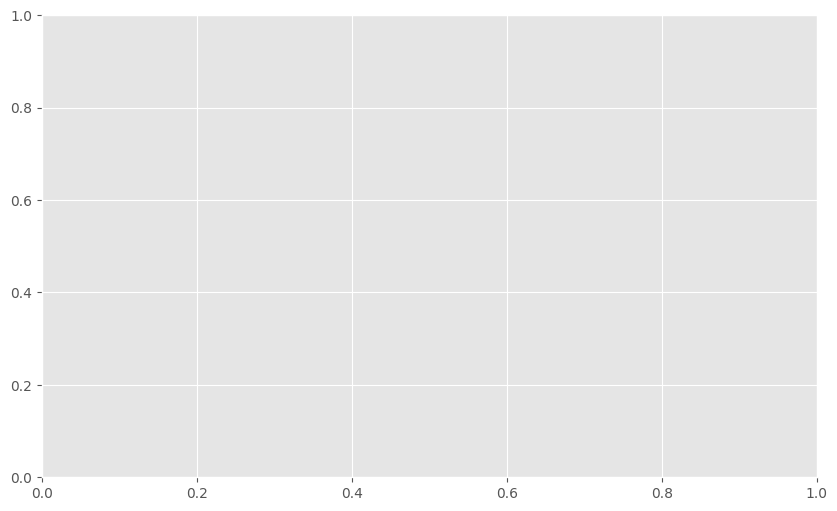

In [82]:
%matplotlib inline
# from IPython.display import display, clear_output
# Create a figure for plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Lists to store rewards and episode numbers
rewards_list = []
episodes = []

def exponential_smoothing(data, alpha=0.1):
    """Compute exponential smoothing."""
    smoothed = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        st = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(st)
    return smoothed

def live_plot(data_dict, figure, ylabel="Total Rewards"):
    """Plot the live graph."""
    clear_output(wait=True)
    ax.clear()
    for label, data in data_dict.items():
        if label == "Total Reward":
            ax.plot(data, label=label, color="yellow", linestyle='--')

            # Compute and plot moving average for total reward
            ma = exponential_smoothing(data)
            ma_idx_start = len(data) - len(ma)
            ax.plot(range(ma_idx_start, len(data)), ma, label="Smoothed Value", linestyle="-", color="purple", linewidth=2)
        else:
            ax.plot(data, label=label)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episode")
    ax.set_title("Live Training Plot")
    ax.legend(loc='upper left')
    display(figure)


# RL Algorithm

In [44]:
def choose_action(model, state_tensor, epsilon):
    state_tensor = state_tensor.unsqueeze(0)
    if random.random() < epsilon:
        return random.randint(0, model(state_tensor).shape[1] - 1)
    with torch.no_grad():
        return model(state_tensor).argmax().item()

In [46]:
# Calculate loss and update Q-network
def calculate_loss(QNet, targetNet, optimizer, state_tensor, action, reward, next_state_tensor, done, gamma):
    state_tensor = state_tensor.unsqueeze(0)
    next_state_tensor = next_state_tensor.unsqueeze(0)

    q_values = QNet(state_tensor)
    with torch.no_grad():
        q_next = targetNet(next_state_tensor)
        target = reward + (0 if done else gamma * q_next.max().item())

    q_target = q_values.clone().detach()
    q_target[0][action] = target

    loss_fn = nn.MSELoss()
    loss = loss_fn(q_values, q_target)

    return loss

## Training loop with live plotting

Use the graph generated here in your pdf submission.

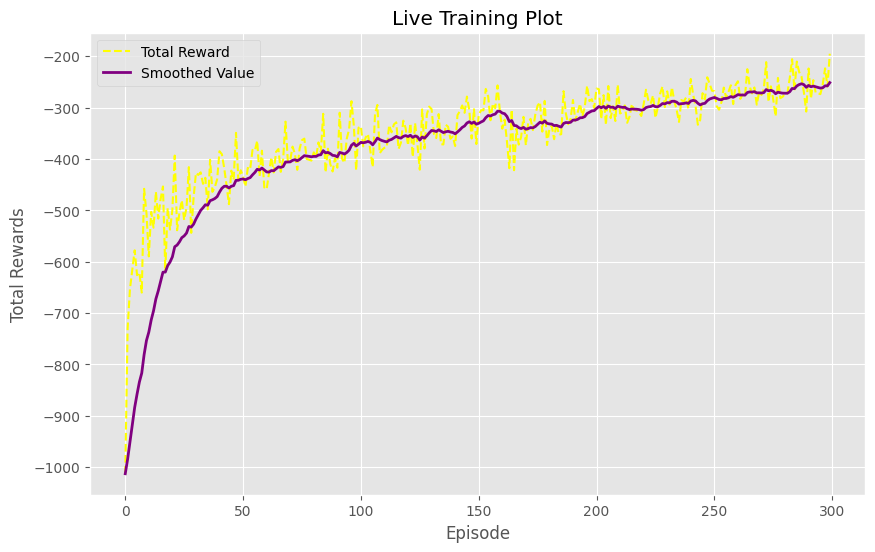

 10%|██▌                       | 300/3000 [5:28:25<55:03:56, 73.42s/it, Total Reward=-195, Loss=0.00065, Epsilon=0.548]

In [ ]:
%matplotlib inline
replay_memory = []
fig, ax = plt.subplots(figsize=(10, 6))

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Create a tqdm progress bar
progress_bar = tqdm.tqdm(range(num_episodes), postfix={'Total Reward': 0, 'Loss': 0})

gamma = 0.8
learning_rate = 1e-4

planning_steps = 80
epsilon_decay = 0.998
epsilon = 1.0
epsilon_min = 0.05

reward_normalizer = RewardNormalizer()

# RL algorithm training loop
for episode in progress_bar:
    total_reward = 0
    state = env.reset()

    while True:
        # Convert the original state to the suitable format for the network
        state_desc = env.disc2state(state)
        state_list = convert_state_to_list(state_desc, env_features)
        state_tensor = torch.tensor(state_list, dtype=torch.float32, device=device)
        #state_tensor = (state_tensor - state_tensor.mean()) / (state_tensor.std() + 1e-8)
        state_tensor = normalize_state(state_tensor) #Normalize States

        action = choose_action(
            ## TODO: FILL IN PARAMS FOR CALLING choose_action
            Qnet, state_tensor, epsilon
        )

        # Take the chosen action and observe the next state and reward
        next_state, reward, done, _ = env.step((action))
        reward = reward_normalizer.normalize(reward)

        # Convert the next state to the suitable format for the network
        next_state_desc = env.disc2state(next_state)
        next_state_list = convert_state_to_list(next_state_desc, env_features)
        next_state_tensor = torch.tensor(next_state_list, dtype=torch.float32, device=device)
        next_state_tensor = normalize_state(next_state_tensor) #Normalize States


        # Hint: You may want to collect experiences from the environment to update the agent in batches!
        replay_buffer.push(state_tensor, action, reward, next_state_tensor, done)

        # loss = calculate_loss(Qnet, targetNet, optimizer, state_tensor, action, reward, next_state_tensor, done, gamma)

        # optimizer.zero_grad()
        # loss.backward()
        # #Clip Gradient
        # torch.nn.utils.clip_grad_norm_(Qnet.parameters(), max_norm=1.0)
        # optimizer.step()

        #Batch Update
        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            for s, a, r, ns, d in batch:
                #Normalize Rewards
                r = reward_normalizer.normalize(r)

                #Normalize States
                s = normalize_state(s)
                ns = normalize_state(ns)

                loss = calculate_loss(Qnet, targetNet, optimizer, s, a, r, ns, d, gamma)
                optimizer.zero_grad()
                #Clip Gradient
                torch.nn.utils.clip_grad_norm_(Qnet.parameters(), max_norm=1.0)
                loss.backward()
                optimizer.step()

        if len(replay_buffer) >= batch_size:
            for _ in range(planning_steps):
                s, a, r, ns, d = random.choice(replay_buffer.buffer)

                #Normalize Rewards
                r = reward_normalizer.normalize(r)

                #Normalize States
                s = normalize_state(s)
                ns = normalize_state(ns)

                loss_p = calculate_loss(Qnet, targetNet, optimizer,s, a, r, ns, d, gamma)
                optimizer.zero_grad()
                #Clip Gradient
                torch.nn.utils.clip_grad_norm_(Qnet.parameters(), max_norm=1.0)
                loss_p.backward()
                optimizer.step()

        state = next_state
        total_reward += reward

        if done:
            break

    if episode % 10 == 0:
        targetNet.load_state_dict(Qnet.state_dict())

    rewards_list.append(total_reward)
    episodes.append(episode)

    #epsilon decay
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    live_plot({'Total Reward': rewards_list}, fig)

    # Saving the model
    if episode%500 == 0:
      torch.save(Qnet, f'model.pt')

    progress_bar.set_postfix({'Total Reward': total_reward, 'Loss': loss.item(), 'Epsilon': epsilon})

## Compute the mean rewards

Report the mean rewards obtained in your pdf submission

In [33]:
mean_rewards = sum(rewards_list) / len(rewards_list)
print(f"\nMean Rewards: {mean_rewards}")

# close the environment
env.close()


Mean Rewards: -164933.4092887557


In [24]:
torch.save(Qnet, './modelDynaQ.pt')

In [28]:
final_model = torch.load('./modelDynaQ.pt', weights_only=False)
final_model.eval()

trained_network = final_model

In [29]:
is_render = True
render_path = './' # path to the folder on your google drive
env = Elevator(is_render=is_render, render_path=render_path, instance = 5)

# reset environment
state = env.reset(seed=40)

total_reward = 0
for t in range(env.horizon):
    state_desc = env.disc2state(state)
    state_list = convert_state_to_list(state_desc, env_features)
    state_tensor = torch.tensor(state_list, dtype=torch.float32, device=device)
    state_tensor = normalize_state(state_tensor) #Normalize States

    # sample random action
    action = choose_action(
            ## TODO: FILL IN PARAMS FOR CALLING choose_action
            Qnet, state_tensor, epsilon
        )

    # take an action
    next_state, reward, terminated, info = env.step(action)  # self.env.step(action)

    if is_render:
        env.render()

    total_reward += reward
    print()
    print(f'state      = {state}')
    print(f'action     = {action}')
    print(f'next state = {next_state}')
    print(f'reward     = {reward}')
    print(f'total_reward     = {total_reward}')
    state = next_state

env.close()

/usr/local/lib/python3.11/dist-packages/pyRDDLGym/Examples /usr/local/lib/python3.11/dist-packages/pyRDDLGym/Examples/manifest.csv
Available example environment(s):
MountainCar -> A simple continuous MDP for the classical mountain car control problem.
HVAC -> Multi-zone and multi-heater HVAC control problem
PowerGen_discrete -> A simple power generation problem loosely modeled on the problem of unit commitment.
PowerGen_continuous -> A continuous simple power generation problem loosely modeled on the problem of unit commitment.
Traffic -> BLX/QTM traffic model.
Reservoir_discrete -> Discrete version of management of the water level in interconnected reservoirs.
Reservoir_continuous -> Continuous action version of management of the water level in interconnected reservoirs.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
CartPole_continuous

/usr/local/lib/python3.11/dist-packages/pyRDDLGym/Core/Env/RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(



state      = 2048
action     = 4
next state = 2052
reward     = 0.0
total_reward     = 0.0

state      = 2052
action     = 4
next state = 2116
reward     = -3.0
total_reward     = -3.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -9.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -15.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -21.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -27.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -33.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -39.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -45.0

state      = 2116
action     = 4
next state = 2116
reward     = -6.0
total_reward     = -51.0

state      = 2116
action     = 4
next state = 2116
rew

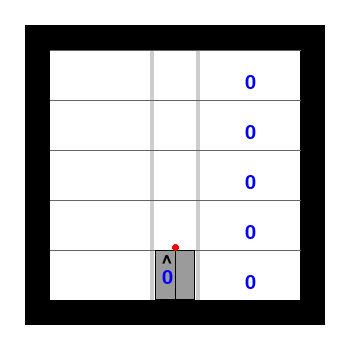

In [32]:
if is_render:
    env.save_render()

from IPython.display import Image

display(Image(filename=f'{render_path}/elevator.gif'))